## Neural Network Model
### Part 1: using selected features
- in_spotify_playlists
- in_apple_charts
- in_shazam_charts
- danceability_%
- bpm_normalized
- valence_%
- energy_%

In [1]:
import numpy as np
import torch
import pandas as pd
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
# Custom Dataset:

# - in_spotify_playlists
# - in_apple_charts
# - in_shazam_charts
# - danceability_%
# - bpm_normalized
# - valence_%
# - energy_%

class songsDataset(Dataset):
    def __init__(self, dataframe, device):
        self.dataframe = dataframe
        self.device = device

        self.scaler = StandardScaler()
        self.scaler.fit(self.dataframe[['danceability_%', 'bpm_normalized', 'valence_%', 'energy_%', 'streams']])
        self.dataframe[['danceability_%', 'bpm_normalized', 'valence_%', 'energy_%', 'streams']] = self.scaler.transform(self.dataframe[['danceability_%', 'bpm_normalized', 'valence_%', 'energy_%', 'streams']])

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        features = torch.tensor([
            row['in_spotify_playlists'], 
            row['in_apple_charts'], 
            row['in_shazam_charts'], 
            row['danceability_%'], 
            row['bpm_normalized'], 
            row['valence_%'], 
            row['energy_%']
        ], dtype=torch.float).to(self.device)

        streams = torch.tensor(row['streams'], dtype=torch.float).to(self.device)

        return features, streams

In [3]:
def create_dataloaders(csv_file, batch_size, device, val_split=0.2, test_split = 0.1):
    df = pd.read_csv(csv_file)
    dataset = songsDataset(df, device)

    val_size = int(len(dataset) * val_split)
    test_size = int(len(dataset) * test_split)
    train_size = len(dataset) - val_size - test_size

    train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    return train_loader, val_loader, test_loader

In [4]:
class songsModel(nn.Module):
    def __init__(self):
        super(songsModel, self).__init__()
        self.fc1 = nn.Linear(7, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32,1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [5]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device):
    train_losses, val_losses = [], []
    train_maes, val_maes = [], []
    train_mses, val_mses = [], []
    train_r2s, val_r2s = [], []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_outputs = []
        train_targets = []

        for features, streams in train_loader:
            features, streams = features.to(device), streams.to(device)
            optimizer.zero_grad()
            outputs = model(features)
            loss = criterion(outputs, streams.unsqueeze(1))
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * features.size(0)

            train_outputs.append(outputs.cpu().detach().numpy())
            train_targets.append(streams.cpu().detach().numpy())

        train_loss /= len(train_loader.dataset)
        train_outputs = np.concatenate(train_outputs).flatten()
        train_targets = np.concatenate(train_targets).flatten()
        train_mae = mean_absolute_error(train_targets, train_outputs)
        train_mse = mean_squared_error(train_targets, train_outputs)
        train_r2 = r2_score(train_targets, train_outputs)

        model.eval()
        val_loss = 0.0
        val_outputs = []
        val_targets = []

        with torch.no_grad():
            for features, streams in val_loader:
                features, streams = features.to(device), streams.to(device)
                outputs = model(features)
                loss = criterion(outputs, streams.unsqueeze(1))
                val_loss += loss.item() * features.size(0)

                val_outputs.append(outputs.cpu().detach().numpy())
                val_targets.append(streams.cpu().detach().numpy())

        val_loss /= len(val_loader.dataset)
        val_outputs = np.concatenate(val_outputs).flatten()
        val_targets = np.concatenate(val_targets).flatten()
        val_mae = mean_absolute_error(val_targets, val_outputs)
        val_mse = mean_squared_error(val_targets, val_outputs)
        val_r2 = r2_score(val_targets, val_outputs)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_maes.append(train_mae)
        val_maes.append(val_mae)
        train_mses.append(train_mse)
        val_mses.append(val_mse)
        train_r2s.append(train_r2)
        val_r2s.append(val_r2)

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, '
              f'Train MAE: {train_mae:.4f}, Val MAE: {val_mae:.4f}, '
              f'Train MSE: {train_mse:.4f}, Val MSE: {val_mse:.4f}, '
              f'Train R^2: {train_r2:.4f}, Val R^2: {val_r2:.4f}')

    return train_losses, val_losses, train_maes, val_maes, train_mses, val_mses, train_r2s, val_r2s

In [6]:
def plot_metrics(train_losses, val_losses, train_maes, val_maes, train_mses, val_mses, train_r2s, val_r2s, skip_epochs=5):
    epochs = range(1 + skip_epochs, len(train_losses) + 1)

    plt.figure(figsize=(14, 12))

    plt.subplot(2, 2, 1)
    plt.plot(epochs, train_losses[skip_epochs:], label='Training Loss')
    plt.plot(epochs, val_losses[skip_epochs:], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.plot(epochs, train_maes[skip_epochs:], label='Training MAE')
    plt.plot(epochs, val_maes[skip_epochs:], label='Validation MAE')
    plt.xlabel('Epochs')
    plt.ylabel('MAE')
    plt.title('Training and Validation MAE')
    plt.legend()

    plt.subplot(2, 2, 3)
    plt.plot(epochs, train_mses[skip_epochs:], label='Training MSE')
    plt.plot(epochs, val_mses[skip_epochs:], label='Validation MSE')
    plt.xlabel('Epochs')
    plt.ylabel('MSE')
    plt.title('Training and Validation MSE')
    plt.legend()

    plt.subplot(2, 2, 4)
    plt.plot(epochs, train_r2s[skip_epochs:], label='Training R^2')
    plt.plot(epochs, val_r2s[skip_epochs:], label='Validation R^2')
    plt.xlabel('Epochs')
    plt.ylabel('R^2')
    plt.title('Training and Validation R^2')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [7]:
def evaluate_model_on_test(model, test_loader, criterion, device):
    model.eval()
    test_loss = 0.0
    test_mae = 0.0
    test_mse = 0.0
    test_outputs = []
    test_targets = []

    with torch.no_grad():
        for features, streams in test_loader:
            features, streams = features.to(device), streams.to(device)
            outputs = model(features)
            loss = criterion(outputs, streams.unsqueeze(1))
            test_loss += loss.item() * features.size(0)
            test_mae += torch.abs(outputs - streams.unsqueeze(1)).sum().item()
            test_outputs.append(outputs.cpu().detach().numpy())
            test_targets.append(streams.cpu().detach().numpy())

    test_loss /= len(test_loader.dataset)
    test_mae /= len(test_loader.dataset)
    test_outputs = np.concatenate(test_outputs).flatten()
    test_targets = np.concatenate(test_targets).flatten()
    test_mse = mean_squared_error(test_targets, test_outputs)
    test_r2 = r2_score(test_targets, test_outputs)

    print(f'Test Loss: {test_loss:.4f}, Test MAE: {test_mae:.4f}, Test MSE: {test_mse:.4f}, Test R^2: {test_r2:.4f}')

    return test_loss, test_mae, test_mse, test_r2

cpu
Epoch 1/150, Train Loss: 10071.3523, Val Loss: 7594.9264, Train MAE: 53.5618, Val MAE: 48.4242, Train MSE: 10071.3535, Val MSE: 7594.9263, Train R^2: -10552.2018, Val R^2: -6018.4842
Epoch 2/150, Train Loss: 3531.3555, Val Loss: 1644.0372, Train MAE: 31.3345, Val MAE: 23.2229, Train MSE: 3531.3555, Val MSE: 1644.0372, Train R^2: -3699.3082, Val R^2: -1302.0088
Epoch 3/150, Train Loss: 533.3328, Val Loss: 167.2778, Train MAE: 13.2608, Val MAE: 7.7876, Train MSE: 533.3328, Val MSE: 167.2778, Train R^2: -557.8493, Val R^2: -131.5788
Epoch 4/150, Train Loss: 120.8634, Val Loss: 149.2026, Train MAE: 5.0627, Val MAE: 5.6564, Train MSE: 120.8634, Val MSE: 149.2026, Train R^2: -125.6459, Val R^2: -117.2530
Epoch 5/150, Train Loss: 154.4977, Val Loss: 166.1927, Train MAE: 5.9979, Val MAE: 6.2221, Train MSE: 154.4977, Val MSE: 166.1927, Train R^2: -160.8894, Val R^2: -130.7187
Epoch 6/150, Train Loss: 132.7346, Val Loss: 110.2887, Train MAE: 5.1992, Val MAE: 4.2954, Train MSE: 132.7346, Val 

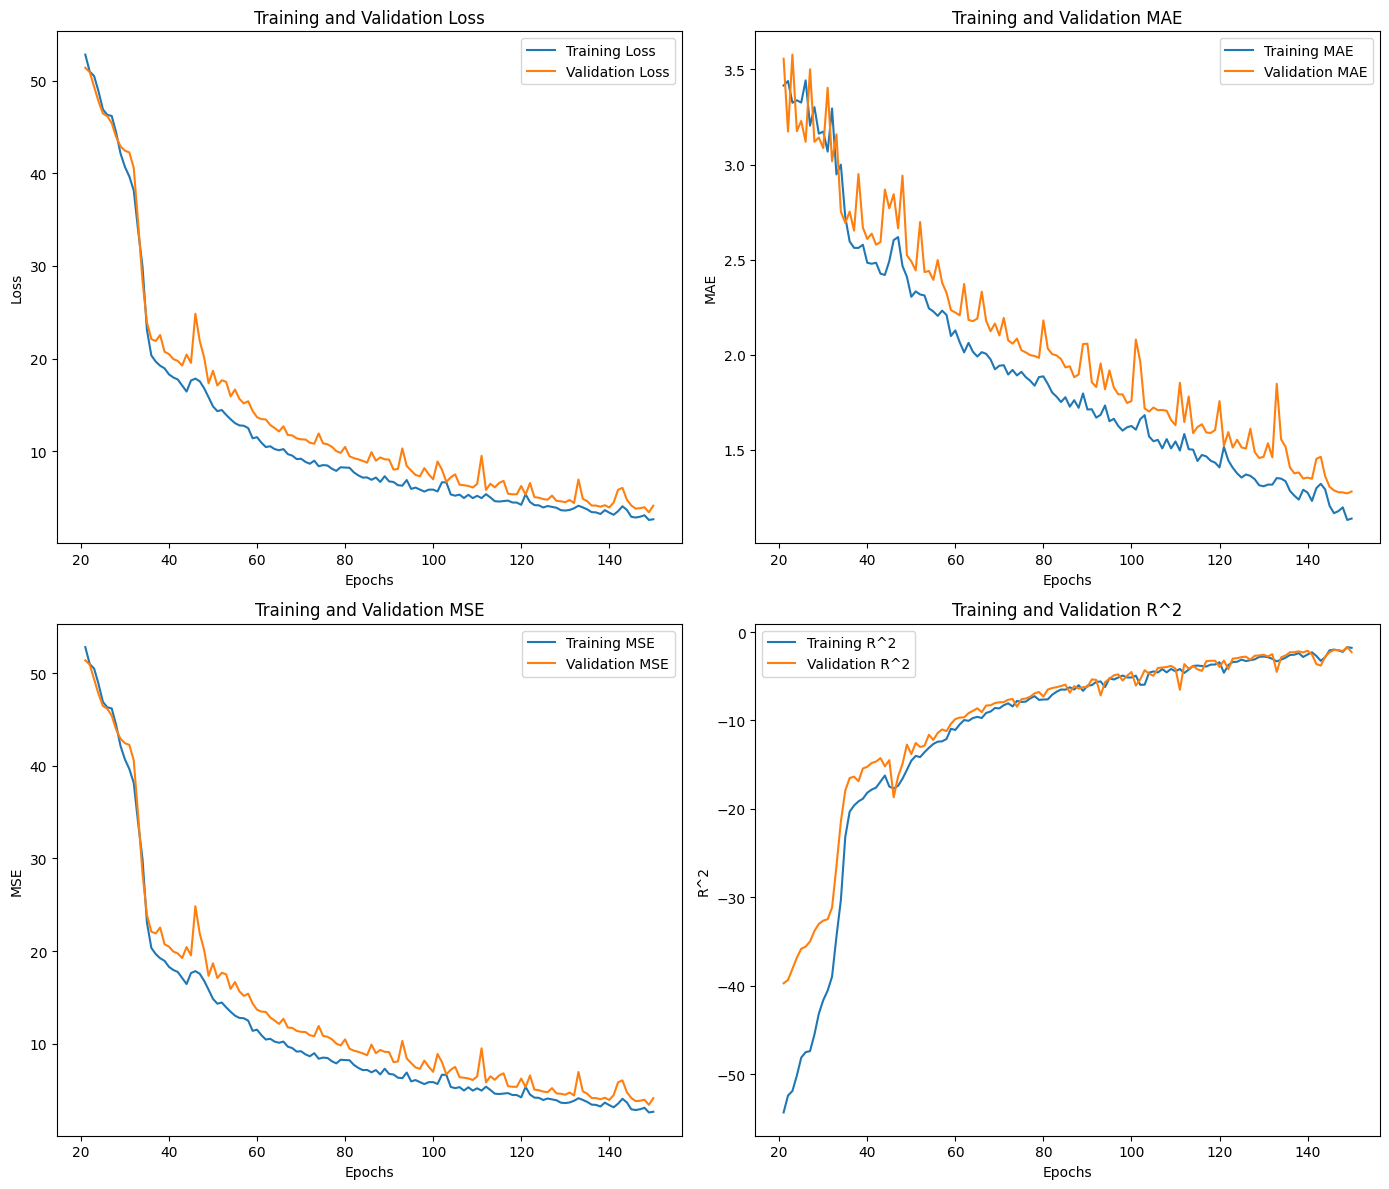

Test Loss: 2.0775, Test MAE: 1.1209, Test MSE: 2.0775, Test R^2: -1.7422


In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

train_loader, val_loader, test_loader = create_dataloaders('preprocessed_popular_spotify_songs.csv', batch_size=64, device=device)
model = songsModel().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00005)
num_epochs = 150

train_losses, val_losses, train_maes, val_maes, train_mses, val_mses, train_r2s, val_r2s = train_model(
    model, train_loader, val_loader, criterion, optimizer, num_epochs, device
)

plot_metrics(train_losses, val_losses, train_maes, val_maes, train_mses, val_mses, train_r2s, val_r2s, skip_epochs=20)

test_loss, test_mae, test_mse, test_r2 = evaluate_model_on_test(model, test_loader, criterion, device)